Author: Stephen W. Thomas, Queen's University

Clustering the 20NewsGroup dataset:

- Load data (from the scikit-learn package)
- Select subset of data
- Preprocess data
- Transform data into a term document matrix (TDM)
- Apply TF-IDF to TDM
- Run K-Means clustering on TDM
- Measure effectiveness
- Output results and examples

In [43]:
from __future__ import print_function

%matplotlib inline

import os
import re
import sys

import nltk.corpus
import nltk.stem
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist, pdist
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load Data

In [2]:
# For now, we'll just use these categories
categories = ['rec.sport.baseball', 'talk.religion.misc', 'comp.graphics','sci.space']
data = fetch_20newsgroups(subset='all', categories=categories, shuffle=False)

# Print some metrics about the data
print("Number of docs: %d:" % len(data.data))
print("Number of categories: %d" % len(data.target_names))
i = 0
for cat in range(len(data.target_names)):
    cat_name = data.target_names[cat]
    num_docs = len([d for d in data.target if d == i])
    print("Category %d (%s): %d docs" % (i, cat_name, num_docs))
    i += 1

labels = data.target
num_categories = np.unique(labels).shape[0]

Number of docs: 3582:
Number of categories: 4
Category 0 (comp.graphics): 973 docs
Category 1 (rec.sport.baseball): 994 docs
Category 2 (sci.space): 987 docs
Category 3 (talk.religion.misc): 628 docs


# Preprocessing

In [3]:
# Define a new member, .pre, to hold the preprocessed version.
data.pre = []

# A list of custom stopwords to remove
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(
    ['would', 'subject', 're', 'don', 'jan',
     'feb', 'mar', 'apr', 'may', 'june',
     'july', 'aug', 'sep', 'oct', 'nov', 'dec'])

# Regex pattern for email addresses
email_pattern = re.compile(r'[^@]+@[^@]+\.[^@]+', re.IGNORECASE & re.UNICODE)

# Regex pattern for things found at the top "header" part of the message
header_pattern = re.compile(
    r'^summary:|^x-newsreader:.*|^date:.*'
    r'|^disclaimer:.*|^distribution:.*|^organization:.*'
    r'|^nntp-posting-host:.*|^keywords:.*|^to:.*'
    r'|^in-reply-to:.*|^x-news-reader:.*|^lines:.*',
    re.IGNORECASE & re.UNICODE)

# Regex pattern for general special characters
#special_char_pattern = re.compile(r'[\|=-\[\]\'\":;,\.\<\>\\\/\?_\(\)!$%^&*,]', re.IGNORECASE & re.UNICODE)
special_char_pattern = re.compile(r"[^\w']|_")

# Regex pattern for whole-word numbers
number_pattern = re.compile(r'\b\d+\b')

# Regex pattern to handle strings like the following:
# In article <me@me.com> me@me.com (Me) writes:
writes_pattern = re.compile(r'^.*writes:$')

# Loop through data do the preprocessing
for j in range(0, len(data.data)):
    lines = data.data[j].lower().split("\n")
    for i in range(0, len(lines)):

        # Use the regexes above to remove bad things
        lines[i] = header_pattern.sub(' ', lines[i])
        lines[i] = email_pattern.sub(' ', lines[i])
        lines[i] = number_pattern.sub(' ', lines[i])
        lines[i] = writes_pattern.sub(' ', lines[i])
        lines[i] = special_char_pattern.sub(' ', lines[i])

        # Remove short words
        lines[i] = ' '.join([w for w in lines[i].split() if len(w) > 2])

        # Remove stopwords
        lines[i] = ' '.join([w for w in lines[i].split() if w not in stopwords])

        # Stem the words
        lines[i] = ' '.join([nltk.stem.snowball.SnowballStemmer("english").stem(w) for w in lines[i].split()])

        # Remove extra spaces, just for beauty
        re.sub('\s\s+', " ", lines[i])

    pre = " ".join(lines)
    data.pre.append(pre)

Preprocessing the data...


# Inspect some of the data

In [44]:
data.pre[0]
data.pre[1]

u" time best player origin news nimast         articl 1993apr13 write  i'v recent work project determin greatest player respect postion  career  johnni hodapp greatest 2nd baseman cleveland indian histori hit consist great great second baseman  header said career hodapp manag nine year major  consist make three year row preced part time year plus last year boston hodapp qualifi bat titl five time  injur retir right around 28th birthday  anyway hodapp put flashi number year everybodi put flashi number realli good year bat year mar lack power inabl draw walk base ball describ fear hitter  hand part long line famous cleveland wambsganss rigg stephenson etc  roger  jon johnni hodapp      "

In [42]:
# Look at some of the most frequent words
tokens = []
for pre in data.pre:
    [tokens.append(w) for w in pre.split()]
print("Total terms: {}\n".format(len(tokens)))
num_unique_terms = len(set(tokens))
print("Unique terms: {}\n".format(num_unique_terms))
text = nltk.Text(tokens)
fdist1 = nltk.probability.FreqDist(text)
print("Term frequencies:\n")
for w in fdist1.most_common(num_unique_terms):
    print("{}, {}\n".format(w[1], w[0].encode("utf-8")))

Total terms: 476206

Unique terms: 23675

Term frequencies:

2689, one

2417, use

2225, imag

2039, space

2030, like

1841, get

1795, year

1736, don't

1694, know

1661, time

1608, think

1566, also

1404, say

1316, file

1315, see

1314, make

1303, good

1288, peopl

1234, look

1207, game

1193, graphic

1188, program

1185, system

1179, it

1160, could

1160, first

1144, god

1124, well

1063, point

1051, even

1046, much

1031, run

1026, want

1015, way

1008, work

1000, i'm

993, need

986, thing

970, two

949, mani

937, new

896, data

861, bit

850, post

837, base

829, last

828, jpeg

820, team

819, orbit

817, call

814, better

811, softwar

810, read

801, come

800, christian

800, right

781, format

778, find

776, day

768, take

764, avail

751, anyon

748, mean

748, edu

741, tri

714, includ

712, give

711, back

709, hit

707, help

704, player

703, object

695, problem

695, believ

695, differ

689, inform

689, question

686, pleas

685, launch

# Build the TDM Matrix

In [50]:
vectorizer = TfidfVectorizer(max_df=0.6, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)
tdm = vectorizer.fit_transform(data.pre)

# Get the vocabulary (i.e., terms mapped to their indices)
vocab = vectorizer.vocabulary_

# Inverse the vocabulary (i.e., indices mapped to terms)
ivocab = {}
for term, index in vocab.iteritems():
    ivocab[index] = term
    
print(tdm)

  (0, 9108)	0.167267668648
  (0, 7904)	0.09134834988
  (0, 3114)	0.110683138031
  (0, 5182)	0.0982034313407
  (0, 3381)	0.0919746621306
  (0, 2951)	0.09583519976
  (0, 5052)	0.0497774818912
  (0, 1277)	0.0988782094262
  (0, 749)	0.111555298425
  (0, 7490)	0.107243388878
  (0, 1060)	0.0691342462609
  (0, 5172)	0.0938244096872
  (0, 4249)	0.0678922425092
  (0, 3386)	0.0771952601368
  (0, 7747)	0.178000377484
  (0, 6644)	0.0918480343751
  (0, 8467)	0.18020011392
  (0, 8871)	0.0529276903956
  (0, 3948)	0.0594046414415
  (0, 9820)	0.0883398721759
  (0, 1547)	0.170830014946
  (0, 4176)	0.167267668648
  (0, 6643)	0.0843627877916
  (0, 4487)	0.127573588422
  (0, 9943)	0.0580785693118
  :	:
  (3581, 3006)	0.0973954294298
  (3581, 291)	0.189927641312
  (3581, 1707)	0.160633391743
  (3581, 5835)	0.21528742125
  (3581, 2465)	0.126489704054
  (3581, 1362)	0.120819911974
  (3581, 9951)	0.0648549701533
  (3581, 3001)	0.0631263470188
  (3581, 8121)	0.0850545459341
  (3581, 6657)	0.0609801105273
  (358

# Run the clustering algorithm

In [25]:
# Try a few different values of K; we'll decide later what's the best.

K = range(1,20)
fits = [KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=30, verbose=False).fit(tdm) for k in K]
centroids = [fit.cluster_centers_ for fit in fits]
inertias = [fit.inertia_ for fit in fits]

Running the clustering algorithm...


# Evaluate and Inspect Clusters

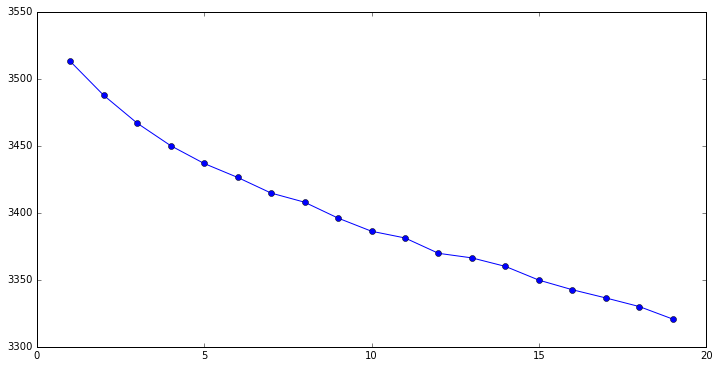

In [27]:
clusters_df = pd.DataFrame( { "num_clusters":K, "cluster_errors": inertias } )

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.show()

In [37]:
# The top terms for each cluster

k = 10 # Let's select k = 10, just for fun.
km = fits[k]


cluster_terms = []

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster {}:\n".format(i))
    print(" Num docs: {}\n".format(len([x for x in km.labels_ if x == i])))
    print(" Top terms:".format(i))
    cterms = []
    for ind in order_centroids[i, :10]:
        print(' {}'.format(terms[ind]))
        cterms.append(terms[ind])
    cluster_terms.append(' '.join(cterms))
    print("\n")

Cluster 0:

 Num docs: 224

 Top terms:
 graphic
 polygon
 card
 mode
 driver
 vga
 packag
 librari
 routin
 need


Cluster 1:

 Num docs: 551

 Top terms:
 space
 orbit
 sky
 nasa
 like
 earth
 satellit
 mission
 moon
 spacecraft


Cluster 2:

 Num docs: 1094

 Top terms:
 thank
 anyon
 mail
 know
 pleas
 use
 like
 time
 new
 look


Cluster 3:

 Num docs: 37

 Top terms:
 jewish
 player
 basebal
 lowenstein
 come
 hank
 koufax
 stankowitz
 sandi
 greenberg


Cluster 4:

 Num docs: 348

 Top terms:
 imag
 file
 format
 gif
 bit
 program
 convert
 tiff
 use
 graphic


Cluster 5:

 Num docs: 306

 Top terms:
 game
 team
 pitch
 win
 run
 score
 brave
 basebal
 pitcher
 morri


Cluster 6:

 Num docs: 169

 Top terms:
 launch
 cost
 moon
 billion
 fund
 year
 space
 develop
 shuttl
 prize


Cluster 7:

 Num docs: 58

 Top terms:
 hst
 mission
 shuttl
 servic
 boost
 group
 split
 array
 orbit
 newsgroup


Cluster 8:

 Num docs: 181

 Top terms:
 god
 jesus
 christian
 christ
 bibl
 law
 l

In [39]:
# Rows are the categories, colums are the clusters
print("Confusion matrix:\n")
cmat = metrics.confusion_matrix(y_true=labels, y_pred=km.labels_)
print(cmat[0:num_categories, 0:k])
print("\nRows:\n")
for i, name in enumerate(data.target_names):
    print(" {}: {}\n".format(i, name))
print("Columns:\n")
for i, terms in enumerate(cluster_terms):
    print(" {}: {}\n".format(i, terms))

Confusion matrix:

[[223   1 403   0 326   0   6  13   0   1]
 [  0   0 371  37   2 306   0   0   0   5]
 [  1 546 205   0  19   0 163  45   0   8]
 [  0   4 115   0   1   0   0   0 181 327]]

Rows:

 0: comp.graphics

 1: rec.sport.baseball

 2: sci.space

 3: talk.religion.misc

Columns:

 0: graphic polygon card mode driver vga packag librari routin need

 1: space orbit sky nasa like earth satellit mission moon spacecraft

 2: thank anyon mail know pleas use like time new look

 3: jewish player basebal lowenstein come hank koufax stankowitz sandi greenberg

 4: imag file format gif bit program convert tiff use graphic

 5: game team pitch win run score brave basebal pitcher morri

 6: launch cost moon billion fund year space develop shuttl prize

 7: hst mission shuttl servic boost group split array orbit newsgroup

 8: god jesus christian christ bibl law love believ peopl say

 9: moral koresh christian say object peopl don fbi think know



In [40]:
print("Homogeneity: {}\n".format(metrics.homogeneity_score(labels, km.labels_)))
print("Completeness: {}\n".format(metrics.completeness_score(labels, km.labels_)))
print("V-measure: {}\n".format(metrics.v_measure_score(labels, km.labels_)))
print("Adjusted Rand-Index: {}\n".format(metrics.adjusted_rand_score(labels, km.labels_)))
print("Silhouette Coefficient: {}\n".format(metrics.silhouette_score(tdm, km.labels_, sample_size=1000)))

Homogeneity: 0.661052582168

Completeness: 0.433546575949

V-measure: 0.523656685456

Adjusted Rand-Index: 0.292092814585

Silhouette Coefficient: 0.0116728926053



# Look at examples

In [48]:
def printDoc(j, data, km, cluster_terms):
    print("Filename: {}".format(os.path.basename(data.filenames[j])))
    print("Truth category: {} ({})".format(data.target[j], data.target_names[data.target[j]]))
    print("Assigned cluster: {} ({})".format(km.labels_[j], cluster_terms[km.labels_[j]]))
    print("\nRaw data:\n")
    print("============ START RAW ==========================\n")
    print(data.data[j].encode("utf-8"))
    print("\n========== END RAW ============================\n")
    lines = textwrap.wrap(data.pre[j].encode("utf-8"), 50)
    print("\nPreprocessed:\n")
    print("============ START PREPROCESSED =================\n")
    for line in lines:
        print(line)
        print("\n")
    print("========== END PREPROCESSED =====================\n")
    print("\n\nFeature vector (sorted, non-zero values only):\n")
    print("Term, Index, Value:\n")

    Xa = tdm.toarray()[j]
    sorted_ind = sorted(range(len(Xa)), key=lambda k: Xa[k])
    for ind in reversed(sorted_ind):
        val = Xa[ind]
        if val > 0:
            print(("{}, {}, {}\n".format(ivocab[ind], ind, val)))
    

In [51]:
printDoc(77, data, km, cluster_terms)

Filename: 60930

Truth category: 2 (sci.space)

Assigned cluster: 2 (thank anyon mail know pleas use like time new look)


Raw data:

============ START RAW ==========================

From: jennise@opus.dgi.com (Milady Printcap the goddess of peripherals)
Subject: Looking for a little research help
Organization: Dynamic Graphics Inc.
Lines: 19
Distribution: usa
NNTP-Posting-Host: opus.dgi.com


Hi,
  
  I'm writing a science fiction script and I'm looking for some
answers to questions regarding the Moon and Earth. My starting point
is an impossible situation.  [I checked with a professor at berkeley
and his response was a VERY helpful "can't happen".] If you enjoy
playing with unusual ideas and are willing answer some questions
please contact me via e-mail (jennise@dgi.com).

  I get extremely annoyed when screen and tele-plays ignore basic
facts about computers that I'm determined to be as scientifically
accurate as I can.


  Sorry for being vague, but I'd like to protect my idea as

In [52]:
printDoc(999, data, km, cluster_terms)

Filename: 61027

Truth category: 2 (sci.space)

Assigned cluster: 6 (launch cost moon billion fund year space develop shuttl prize)


Raw data:

============ START RAW ==========================

From: wallacen@CS.ColoState.EDU (nathan wallace)
Subject:  Level 5
Reply-To: wallacen@CS.ColoState.EDU
Nntp-Posting-Host: sor.cs.colostate.edu
Organization: Colorado State University -=- Computer Science Dept.
Lines: 15

According to a Software engineering professor here, what was actually rated
level five was an ibm unit which produced part of the software for the shuttle,
by not means all of it. 

Interesting note: 90% of the software development groups surveyed were at
level 1. The ibm shuttle groups was the *only* one at level 5!

---
C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/
C/    Nathan F. Wallace                   C/C/           "Reality Is"         C/
C/    e-mail: wallacen@cs.colostate.edu   C/C/    ancient Alphaean proverb    C/
C/C/C/C/C/C/C/C/

In [53]:
printDoc(300, data, km, cluster_terms)

Filename: 104806

Truth category: 1 (rec.sport.baseball)

Assigned cluster: 3 (jewish player basebal lowenstein come hank koufax stankowitz sandi greenberg)


Raw data:

============ START RAW ==========================

From: barrym@informix.com (Barry Mednick)
Subject: Re: Jewish Baseball Players?
Summary: a few names
Organization: Informix Software, Inc.
Lines: 9

In article <15APR93.14691229.0062@lafibm.lafayette.edu> VB30@lafibm.lafayette.edu (VB30) writes:
>Just wondering.  A friend and I were talking the other day, and
>we were (for some reason) trying to come up with names of Jewish
>maybe John Lowenstein.  
Lowenstein is NOT Jewish.  However, there is a long list including
Hank Greenberg, Moe Berg, Rod Carew (a convert), the Sherry brothers,
Art Shamsky, and Ron Blomberg.

Barry


========== END RAW ============================


Preprocessed:

============ START PREPROCESSED =================

 jewish basebal player name     wonder friend talk


day reason tri come name jewis